# Simulation of Experiment 
Protons on Ta181 at the MC40 cyclotron in Birmingham

In [24]:
 %matplotlib inline
# imports
import basic_data_reader as bdr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import fispact_printlib_reader as fpr
import fispact_analysis as fa
import fispact_output_reader

# get basic data
bd = bdr.basic_data()

# colours for plotting
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(len(cycle_colors))

# get gamma line data
linedata = fpr.read_fispact_printlib("Data/decay_lines.out")
linedata = fpr.particle_filter(linedata, 'gamma')
linedata["energy_kev"] = linedata["energy_ev"]/1000

10


In [45]:
# experiment set up
material = "Ta"
thickness = 0.0008  # cm
width = 1          # cm
height = 1         # cm
volume = thickness * width * height
density = bd.get_density_value(material)
mass = volume * density

p_energy = 10.0  # energy in MeV
beam_current = 10 # assumed
irrad_time = 300 # irradiation time in seconds  3600, 900 and 300 are simulated in fispact
cool_time = 600  # time before sample on detector in seconds
count_time = 1800 # time on detector
detector_channels = 8000
geometric_eff = 0.5 # assume foil directly on top of detector

counts = np.zeros(detector_channels)



W179
W179m
W181


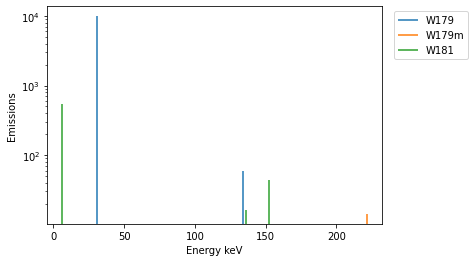

In [48]:
# get fispact simulation output for the start of the count
ef = str(p_energy) + "MeV/"
fn1 = material + "_" + str(p_energy)
if irrad_time == 3600:
    tme_str = "1hr/"
elif irrad_time == 900:
    tme_str = "15min/"
else:
    tme_str = "5min/"
path = "simulations/fispact/"+ tme_str + material + "/TENDL/" + fn1 + ".out"
fout = fispact_output_reader.read_fis_out(path)

# reduce to gamma emitting nuclides with more than 1bq/g,
inv = fout.timestep_data[2].inventory  # need to make it link to cooling time - current set for 10mins
inv = inv[inv["act"] > 1000]   # simulations are for 1kg
inv = fa.filter_emits_gamma(inv)
nucs = inv["nuclide"].unique()

# scale to sample mass
masskg = mass/1000
inv["act"] = inv["act"] * masskg
inv["atoms"] = inv["atoms"] * masskg
inv["mass"] = inv["mass"] * masskg

# calculate number of decays for each nuclide, during count
for i, nuc in enumerate(inv["nuclide"]):
    print(nuc)
    hl = bd.get_hl_value(nuc)
    lamdag = 0.693 / hl
    n0 = inv.loc[inv['nuclide'] == nuc, 'atoms'].item()
    n = n0 * np.exp(-1*lamdag*count_time)
    ndecays = n0 - n

    # now get number of emissions
    nuc_lines = linedata[linedata["nuclide"] == nuc]
    nuc_lines = nuc_lines.drop_duplicates(['energy_kev'])
    nuc_lines["emissions"] = ndecays * (nuc_lines["intensity"]/100)
    
    # plot emissions graph
    style = "solid"
    if i>9:
        i = i - 10
        style = 'dotted'
    plt.vlines(nuc_lines["energy_kev"],  ymin=0, ymax=nuc_lines["emissions"], label=nuc, color=cycle_colors[i], linestyles=style)

    plt.xlabel("Energy keV")
    plt.ylabel("Emissions")
    plt.yscale("log") 
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    
    # attempt to get counts
    for energy in nuc_lines["energy_kev"]:
        channel_num = int(np.floor(energy / (3000/8000)))
        emission = nuc_lines.loc[nuc_lines['energy_kev'] == energy, 'emissions'].item()

        eff = 0.01  # replace with a proper efficiency function
        counts[channel_num] = counts[channel_num] + (eff*emission) 
        # should add broadening
        # should add compton scattering    

plt.show()

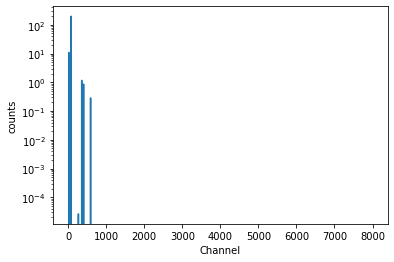

In [49]:
plt.plot(counts)
plt.xlabel("Channel")
plt.ylabel("counts")
plt.yscale("log") 